<a href="https://colab.research.google.com/github/aidantze/pesta-la-vista/blob/yolo_v8_dis/yolov8_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Starter Code**
- Imports
- Checking GPU availability
- Getting the Kaggle set and description of the download




In [1]:
!pip install -q ultralytics kagglehub pyyaml
import torch
import numpy as np
import kagglehub
import pathlib
import yaml
import shutil
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2


In [11]:
# Check for T4 availability on Colab (DON'T CHANGE)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected. Go to Runtime -> Change runtime type ->  GPU")

CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [2]:
# Getting the DATASET from kagglehub
# Kaggle Download via CLI API (see their website - DON'T CHANGE)
path = kagglehub.dataset_download("rupankarmajumdar/crop-pests-dataset")

# Saved the images to a local path to increase efficiency
local_path = pathlib.Path("/content/datasets/crop-pests")
local_path.parent.mkdir(parents=True, exist_ok=True)
shutil.copytree(path, local_path, dirs_exist_ok=True)

# YAML CONGIF (DON'T CHANGE)
data_yaml_path = local_path / "data.yaml"
data_cfg = {
    "path": str(local_path),
    "train": "train/images",
    "val":   "valid/images",
    "test":  "test/images",
    "nc": 12,
    "names":
     [
      "Ants",
      "Bees",
      "Beetles",
      "Catterpillars",     # NOTE: HAD TO CHANGE SPELLING BECAUSE DATASET IMAGES ARE SPELT LIKE THIS
      "Earthworms",
      "Earwigs",
      "Grasshoppers",
      "Moths",
      "Slugs",
      "Snails",
      "Wasps",
      "Weevils",
    ]
}

with open(data_yaml_path, "w") as f:
    yaml.safe_dump(data_cfg, f)


# CHECKS
# Count images in the train, valid, and test directories
num_train_images = len(list((local_path / "train" / "images").glob("*.jpg")))
num_val_images = len(list((local_path / "valid" / "images").glob("*.jpg")))
num_test_images = len(list((local_path / "test" / "images").glob("*.jpg")))

# Count labels in the train, valid, and test directories
num_train_labels = len(list((local_path / "train" / "labels").glob("*.txt")))
num_val_labels = len(list((local_path / "valid" / "labels").glob("*.txt")))
num_test_labels = len(list((local_path / "test" / "labels").glob("*.txt")))

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of test images: {num_test_images}")
print(f"Number of training labels: {num_train_labels}")
print(f"Number of validation labels: {num_val_labels}")
print(f"Number of test labels: {num_test_labels}")


Using Colab cache for faster access to the 'crop-pests-dataset' dataset.


KeyboardInterrupt: 

# **Our Evaluation Metrics**
- Validation loss
- Training loss
- Diference between validation and training loss **-> Less than 0.5**
- mAP@0.5 >= 0.5
- mAP@0.5:0.95 (elps you detect over/under-sized bounding boxes)
- Precision (false positive control)
- Recall (false negative control)
- F1 score


### **Advanced analytics:**

- IoU Mean & Std(checks localisation consistency)
- Inference time/FPS (checking for efficiency trade off)


In [ ]:
def base_evaluation_metrics(val_results, train_res):
  results_path = os.path.join(train_res.save_dir, 'results.csv')
  results_df = pd.read_csv(results_path)

  # Extract validation metrics from YOLOv8 val_results object
  metrics = val_results.results_dict
  precision = metrics.get('metrics/precision(B)', 0)
  recall    = metrics.get('metrics/recall(B)', 0)
  mAP50     = metrics.get('metrics/mAP50(B)', 0)
  mAP50_95  = metrics.get('metrics/mAP50-95(B)', 0)
  f1_score  = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

  print(f"\nMean Average Precision (mAP@0.5):       {mAP50:.4f}")
  print(f"Mean Average Precision (mAP@0.5:0.95):  {mAP50_95:.4f}")
  print(f"Precision: {precision:.4f}  |  Recall: {recall:.4f}  |  F1-score: {f1_score:.4f}")

In [ ]:
def calculate_iou(box1, box2):
    # Convert to [x_min, y_min, x_max, y_max] format
    box1_xmin = box1['center_x'] - box1['width'] / 2
    box1_ymin = box1['center_y'] - box1['height'] / 2
    box1_xmax = box1['center_x'] + box1['width'] / 2
    box1_ymax = box1['center_y'] + box1['height'] / 2

    box2_xmin = box2['center_x'] - box2['width'] / 2
    box2_ymin = box2['center_y'] - box2['height'] / 2
    box2_xmax = box2['center_x'] + box2['width'] / 2
    box2_ymax = box2['center_y'] + box2['height'] / 2

    # Get the coordinates of the intersection rectangle
    inter_xmin = max(box1_xmin, box2_xmin)
    inter_ymin = max(box1_ymin, box2_ymin)
    inter_xmax = min(box1_xmax, box2_xmax)
    inter_ymax = min(box1_ymax, box2_ymax)

    # Calculate intersection area (the bonding boxes)
    inter_width = max(0, inter_xmax - inter_xmin)
    inter_height = max(0, inter_ymax - inter_ymin)
    inter_area = inter_width * inter_height

    # Calculate union area
    box1_area = box1['width'] * box1['height']
    box2_area = box2['width'] * box2['height']
    union_area = box1_area + box2_area - inter_area

    # Calculate IoU
    if union_area > 0:
      iou = inter_area / union_area
    else:
      iou = 0

    return iou


In [ ]:
def IoUmeanstd(test_res):
    dataset_path = pathlib.Path("/content/datasets/crop-pests")
    iou_values = []
    iou_threshold = 0.5
    for res in test_res:
        image_path = res.path
        gt_path = dataset_path / "test" / "labels" / f"{os.path.splitext(os.path.basename(image_path))[0]}.txt"


        # Load ground truth boxes
        gt_boxes = []
        for line in open(gt_path):
            c, x, y, w, h = map(float, line.split())
            gt_boxes.append({'class_id': int(c), 'center_x': x, 'center_y': y, 'width': w, 'height': h})

        # Load predicted boxes
        pred_boxes = res.boxes.xywhn.tolist()

        matched_gt = set()
        for pred in pred_boxes:
            pred_box = {'center_x': pred[0], 'center_y': pred[1], 'width': pred[2], 'height': pred[3]}
            best_iou, best_idx = 0, -1

            # Match with highest IoU
            for i, gt_box in enumerate(gt_boxes):
                if i not in matched_gt:
                    current_iou = calculate_iou(pred_box, gt_box)
                    if current_iou > best_iou:
                        best_iou, best_idx = current_iou, i

            # Keep iou if above threshold
            if best_iou >= iou_threshold and best_idx != -1:
                iou_values.append(best_iou)
                matched_gt.add(best_idx)

    if iou_values:
        mean_iou = np.mean(iou_values)
        std_iou = np.std(iou_values)
        print(f"\nMean IoU: {mean_iou:.4f}")
        print(f"Standard Deviation of IoU: {std_iou:.4f}")
        return mean_iou, std_iou
    else:
        print("\nIoU values were not calculated, cannot compute mean and standard deviation.")
        return None, None


In [ ]:
def get_inference_time_and_fps(test_res):

    if not test_res:
        print("No prediction results provided.")
        return None, None

    total_inference_time = 0
    num_images = len(test_res)

    for res in test_res:
        # Note: 'speed' is a dictionary with different stages, 'inference' is the one we need
        if hasattr(res, 'speed') and 'inference' in res.speed:
            total_inference_time += res.speed['inference']
        else:
            print("Warning: Could not find inference speed in one of the results.")
            return None, None


    # Convert total inference time from milliseconds to seconds
    total_inference_time_seconds = total_inference_time / 1000.0

    # Calculate FPS
    fps = num_images / total_inference_time_seconds if total_inference_time_seconds > 0 else 0

    print(f"\nTotal Inference Time: {total_inference_time_seconds:.4f} seconds")
    print(f"Frames Per Second (FPS): {fps:.4f}")

    return total_inference_time_seconds, fps

# **Our Base Model**

In [ ]:
# Training the Model (as per YOLOv8n website)
model = YOLO("yolov8n.pt")

# See changes made to increase for Colab
train_res = model.train(
    data=str(data_yaml_path),
    epochs=50,          # 50 by default for full convergence
    imgsz=640,           # default image size
    batch=-1,            # auto-adjust batch size
    device=0,            # GPU
    project="pests_base",
    name="yolov8n_default",
    verbose=True
)

# Validate the Model (as per YOLOv8n website)
val_results = model.val(
    data=str(data_yaml_path),
    split="val",
    batch=16,
    device=0,
)

# Test the Model (as per YOLOv8n website)
sample_dir = local_path / "test" / "images"
test_res = model.predict(
    source=str(sample_dir),
    imgsz=640,
    conf=0.25,
    device=0,
    save=True,
    project="runs/detect",
    name="pest_predictions"
)

In [ ]:
base_evaluation_metrics(val_results, train_res)

In [ ]:
IoUmeanstd(test_res)

In [ ]:
get_inference_time_and_fps(test_res)

# **Understanding the training, validating and testing dataset**
Training
- how many images per class?

Validating
- how many images per class?

Testing
- how many images per class?
- how many were "no detection" in each class?
- how many were "misclassifies" in each class?



In [ ]:
# Dataset Analysis: Images per Class

root = Path("/content/datasets/crop-pests")

# Load class names
data_yaml_path = os.path.join(root, "data.yaml")
with open(data_yaml_path, "r") as f:
    names = yaml.safe_load(f)["names"]

# Create a lowercase version of the names list for easier comparison
names_new = [name.lower() for name in names]

# Init counters for images per class for each split
class_count = {split: {name: 0 for name in names} for split in ["train", "valid", "test"]}

# Iterate over train, valid, test and count images per class
for split in ["train", "valid", "test"]:
    image_dir = root / split / "images"
    # NOTE: Extracting the class name from the filenames instead of labels.
    for image_file in image_dir.glob("*.jpg"):
        filename = image_file.stem
        parts = filename.split('-')
        if len(parts) > 1:
            extracted_name = parts[0]
        else:
            parts = filename.split('_')
            extracted_name = parts[0]

        extracted_name_lower = extracted_name.lower()
        # accounting for any uppercase, plural variants
        if extracted_name_lower in names_new:
            original_name_index = names_new.index(extracted_name_lower)
            class_name = names[original_name_index]
            class_count[split][class_name] += 1
        elif extracted_name_lower + 's' in names_new:
             original_name_index = names_new.index(extracted_name_lower + 's')
             class_name = names[original_name_index]
             class_count[split][class_name] += 1
        else:
            print(f"Warning: Class name '{extracted_name}' extracted from filename '{filename}' not found in names.")


# Generate plots for image counts
for split, counts in class_count.items():
    # CHECK
    total_images = len(list((root / split / "images").glob("*.jpg")))
    print(f"\nTotal images in {split} set: {total_images}")

    plt.figure(figsize=(12, 6))
    class_names = list(counts.keys())
    image_counts = list(counts.values())
    plt.bar(class_names, image_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"Number of Images per Class in {split.capitalize()} Set")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [ ]:
# MATCHING ACTUAL BOXES TO PREDICTED BOXES -  prework for evaluations

matched_predictions = {}
unmatched_ground_truths = {}

# Establish threshold
iou_threshold = 0.5

# Going through each prediction given by Ultraytics
for res in test_res:
    image_path = res.path
    pred_boxes_raw = res.boxes.xywhn.tolist()
    pred_classes_raw = res.boxes.cls.tolist()
    pred_confidences_raw = res.boxes.conf.tolist()

    # Creates a dict with xywh, class_id.
    pred_data = []
    for i in range(len(pred_boxes_raw)):
        pred_data.append({
            'center_x': pred_boxes_raw[i][0],
            'center_y': pred_boxes_raw[i][1],
            'width': pred_boxes_raw[i][2],
            'height': pred_boxes_raw[i][3],
            'class_id': int(pred_classes_raw[i]),
            'confidence': pred_confidences_raw[i]
        })

    # Construct the corresponding ground truth label file path
    label_filename = os.path.splitext(os.path.basename(image_path))[0] + ".txt"
    ground_truth_path = os.path.join(local_path, "test", "labels", label_filename)

    # Getting the actual box from the labels
    actual_box = []
    try:
        with open(ground_truth_path, 'r') as f:
            for line in f:
                class_id, center_x, center_y, width, height = map(float, line.strip().split())
                actual_box.append({
                    'class_id': int(class_id),
                    'center_x': center_x,
                    'center_y': center_y,
                    'width': width,
                    'height': height
                })
    except FileNotFoundError:
        print(f"Warning: Ground truth file not found for {os.path.basename(ground_truth_path)}")
        actual_box = []

    matched_predictions[image_path] = []
    #NOTE: Nothing is matched yet
    unmatched_ground_truths[image_path] = list(actual_box)


    matched_gt_indices = set()
    # for each predi ted box, find the singles best actual box
    for pred_box in pred_data:
        best_iou = 0
        best_gt_index = -1

        for j in range(len(actual_box)):
            if j not in matched_gt_indices:
                # Remove the incorrect assignment
                # actual_box = actual_box[j] # REMOVE THIS LINE
                current_iou = calculate_iou(pred_box, actual_box[j]) # Use actual_box[j]


                if current_iou > best_iou:
                    best_iou = current_iou
                    best_gt_index = j

        if best_iou >= iou_threshold and best_gt_index != -1:
            matched_predictions[image_path].append({
                'predicted': pred_box,
                'ground_truth': actual_box[best_gt_index],
                'iou': best_iou
            })
            matched_gt_indices.add(best_gt_index)

    # Remove matched ground truths from unmatched_ground_truths for this image
    unmatched_ground_truths[image_path] = [
        gt_box for k, gt_box in enumerate(actual_box) if k not in matched_gt_indices
    ]
#CHECK
print("Comparison completed. Results stored in 'matched_predictions' and 'unmatched_ground_truths'.")

In [ ]:

# Analyze False Negatives, False Positives, and Misclassifications

# Initialize dictionaries for counts
false_negatives = {name: 0 for name in names}
false_positives = {name: 0 for name in names}
misclassified_counts = {name: 0 for name in names}


# Count false negatives (unmatched ground truths)
for image_path, actual_boxes in unmatched_ground_truths.items():
    for actual_box in actual_boxes:
        actual_class_name = names[actual_box['class_id']]
        false_negatives[actual_class_name] += 1

# Count false positives (predicted boxes without a match) and misclassifieds
for res in test_res:
    image_path = res.path
    pred_boxes_raw = res.boxes.xywhn.tolist()
    pred_classes_raw = res.boxes.cls.tolist()

    predicted_data_for_image = []
    for i in range(len(pred_boxes_raw)):
         predicted_data_for_image.append({
            'center_x': pred_boxes_raw[i][0],
            'center_y': pred_boxes_raw[i][1],
            'width': pred_boxes_raw[i][2],
            'height': pred_boxes_raw[i][3],
            'class_id': int(pred_classes_raw[i]),
        })

    # Get the matched predicted boxes for the current image
    matched_pred_boxes_for_image = [match['predicted'] for match in matched_predictions.get(image_path, [])]

    for pred_box in predicted_data_for_image:
        is_false_positive = True
        for matched_pred_box in matched_pred_boxes_for_image:
            # Compare dictionaries for equality (excluding confidence for this check)
            if pred_box['center_x'] == matched_pred_box['center_x'] and \
               pred_box['center_y'] == matched_pred_box['center_y'] and \
               pred_box['width'] == matched_pred_box['width'] and \
               pred_box['height'] == matched_pred_box['height'] and \
               pred_box['class_id'] == matched_pred_box['class_id']:
                is_false_positive = False
                break

        if is_false_positive:
            pred_class_name = names[pred_box['class_id']]
            false_positives[pred_class_name] += 1


# Count misclassifieds from matched predictions
for image_path, matches in matched_predictions.items():
    for match in matches:
        predicted_box = match['predicted']
        ground_truth_box = match['ground_truth']
        if predicted_box['class_id'] != ground_truth_box['class_id']:
            actual_class_name = names[ground_truth_box['class_id']]
            misclassified_counts[actual_class_name] += 1


# Generate bar charts for these counts
plt.figure(figsize=(12, 6))
classes = list(false_negatives.keys())
counts = list(false_negatives.values())
plt.bar(classes, counts)
plt.xlabel("Class")
plt.ylabel("Number of False Negatives")
plt.title("Number of False Negatives per Class (Missed Detections)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
classes = list(false_positives.keys())
counts = list(false_positives.values())
plt.bar(classes, counts)
plt.xlabel("Class")
plt.ylabel("Number of False Positives")
plt.title("Number of False Positives per Class (Wrong Detections)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
classes = list(misclassified_counts.keys())
counts = list(misclassified_counts.values())
plt.bar(classes, counts)
plt.xlabel("Class")
plt.ylabel("Number of Misclassified Objects")
plt.title("Number of Misclassified Objects per Class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
interest_names = names
class_ids_of_interest = [names.index(c) for c in interest_names]
# Initialize lists to store true and predicted labels for the confusion matrix
y_true = []
y_pred = []

# Process matched predictions
for image_path, matches in matched_predictions.items():
    for match in matches:
        predicted_box = match['predicted']
        actual_box = match['ground_truth']

        # Only include if both actual box and predicted classes are in the classes of interest
        if actual_box['class_id'] in class_ids_of_interest and predicted_box['class_id'] in class_ids_of_interest:
            y_true.append(actual_box['class_id'])
            y_pred.append(predicted_box['class_id'])
        elif actual_box['class_id'] in class_ids_of_interest and predicted_box['class_id'] not in class_ids_of_interest:
             # NOTE: If ground truth is of interest but prediction is not, we are considering  it a misclassification.
             # A more complex approach would involve an 'other' category in the matrix, where we can't explicitely state it.
             pass
        elif actual_box['class_id'] not in class_ids_of_interest and predicted_box['class_id'] in class_ids_of_interest:
             # NOTE: If prediction is of interest but ground truth is not, consider it a false positive for the predicted class.
             pass


# Handle false negatives for the classes of interest
for image_path, true_boxes in unmatched_ground_truths.items():
    for true_box in true_boxes:
        if true_box['class_id'] in class_ids_of_interest:
            # This is a false negative for this class
            y_true.append(true_box['class_id'])
            # NOTE: Using len(names) as a placeholder for 'no detection'
            y_pred.append(len(names))


# Create a mapping from original class ID to new class ID
original_to_new_class_id = {original_id: new_id for new_id, original_id in enumerate(class_ids_of_interest)}
original_to_new_class_id[len(names)] = len(interest_names)
y_true_mapped = [original_to_new_class_id[label] for label in y_true]
y_pred_mapped = [original_to_new_class_id[label] for label in y_pred]


# Define labels for the confusion matrix plot
confusion_matrix_labels = interest_names + ["No Detection"]

# Generate the confusion matrix
cm = confusion_matrix(y_true_mapped, y_pred_mapped, labels=range(len(confusion_matrix_labels)))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=confusion_matrix_labels,
            yticklabels=confusion_matrix_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Selected Classes')
plt.show()

In [ ]:
# Analyze Confidence for Matched Predictions (True Positives and Misclassifications)
correct_confidences = {name: [] for name in names}
misclassified_confidences = {name: [] for name in names}

for image_path, matches in matched_predictions.items():
    # Getting each prediction's confidence and its correponding actual class
    for match in matches:
        predicted_box = match['predicted']
        actual_box = match['ground_truth']
        confidence = predicted_box['confidence']
        true_class_name = names[actual_box['class_id']]
        # Accounting for the cases: they are same and they are different
        if predicted_box['class_id'] == actual_box['class_id']:
            correct_confidences[true_class_name].append(confidence)
        else:
            misclassified_confidences[true_class_name].append(confidence)


# Analyze Confidence for False Positives
false_positive_confidences = {name: [] for name in names}

for res in test_res:
    image_path = res.path
    pred_boxes_raw = res.boxes.xywhn.tolist()
    pred_classes_raw = res.boxes.cls.tolist()
    pred_confidences_raw = res.boxes.conf.tolist()

    predicted_data_for_image = []
    for i in range(len(pred_boxes_raw)):
         predicted_data_for_image.append({
            'center_x': pred_boxes_raw[i][0],
            'center_y': pred_boxes_raw[i][1],
            'width': pred_boxes_raw[i][2],
            'height': pred_boxes_raw[i][3],
            'class_id': int(pred_classes_raw[i]),
            'confidence': pred_confidences_raw[i]
        })

    # Get the matched predicted boxes for the current image
    matched_pred_boxes_for_image = [match['predicted'] for match in matched_predictions.get(image_path, [])]

    for pred_box in predicted_data_for_image:
        is_false_positive = True
        for matched_pred_box in matched_pred_boxes_for_image:
            # Compare dictionaries for equality
            if pred_box == matched_pred_box:
                is_false_positive = False
                break

        if is_false_positive:
            pred_class_name = names[pred_box['class_id']]
            false_positive_confidences[pred_class_name].append(pred_box['confidence'])


# Calculate Average Confidences
avg_correct_confidences = {name: np.mean(confidences) if confidences else 0 for name, confidences in correct_confidences.items()}
avg_misclassified_confidences = {name: np.mean(confidences) if confidences else 0 for name, confidences in misclassified_confidences.items()}
avg_false_positive_confidences = {name: np.mean(confidences) if confidences else 0 for name, confidences in false_positive_confidences.items()}

# Visualise Confidence Distributions
classes = list(names)
bar_width = 0.25
r1 = np.arange(len(classes))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(14, 7))
plt.bar(r1, [avg_correct_confidences[c] for c in classes], color='skyblue', width=bar_width, edgecolor='grey', label='Correctly Classified')
plt.bar(r2, [avg_misclassified_confidences[c] for c in classes], color='salmon', width=bar_width, edgecolor='grey', label='Misclassified')
plt.bar(r3, [avg_false_positive_confidences[c] for c in classes], color='lightgreen', width=bar_width, edgecolor='grey', label='False Positive')
plt.xlabel('Class', fontweight='bold')
plt.ylabel('Average Confidence', fontweight='bold')
plt.title('Average Confidence per Class for Different Detection Outcomes', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(classes))], classes, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


# Summarise Findings
print("\nAverage Confidence per Class:\n")

for class_name in classes:
    print(f"{class_name}:")
    print(f"  Correctly Classified: {avg_correct_confidences[class_name]:.4f}")
    print(f"  Misclassified:        {avg_misclassified_confidences[class_name]:.4f}")
    print(f"  False Positive:       {avg_false_positive_confidences[class_name]:.4f}")

# **Initial Limitations**
- **mAP@0.5 = 0.61 and mAP@0.5:0.95 = 0.34:** This indicates a large gap , meaning localisation quality across high IoUs is an issue.
- **Precision > Recall:** It seems that we are missing objects more than mislabelling them.
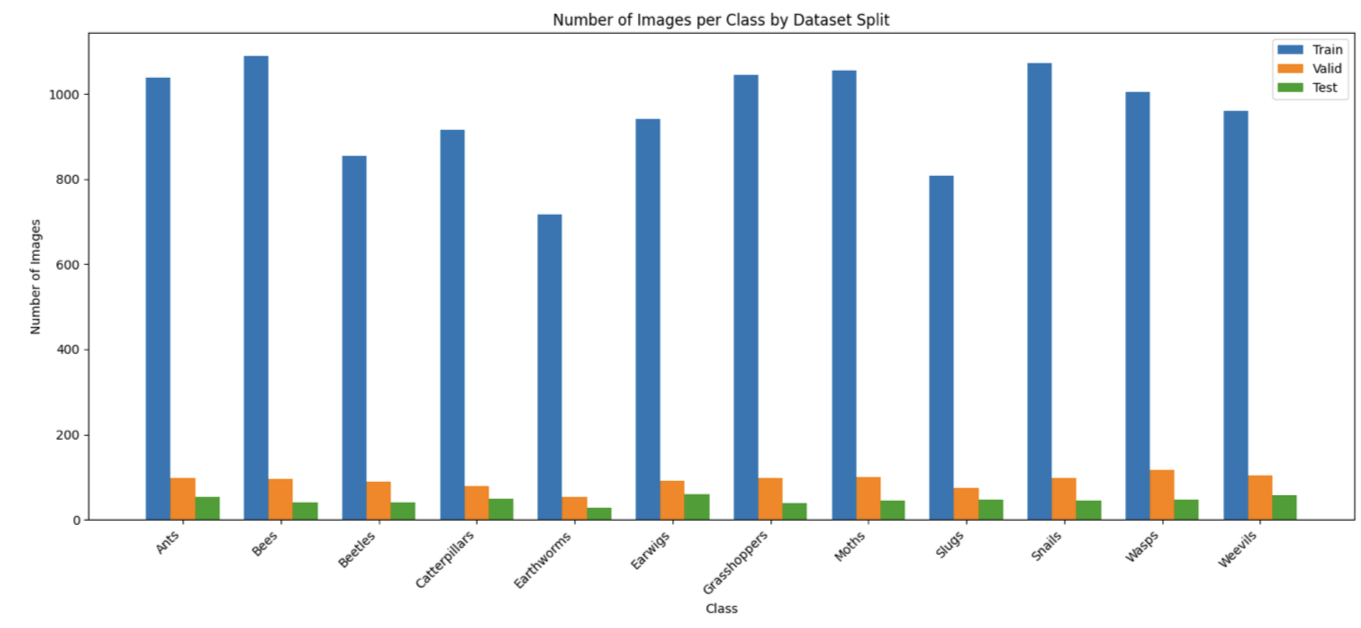


- There is a class data imbalance in training and validating sets.

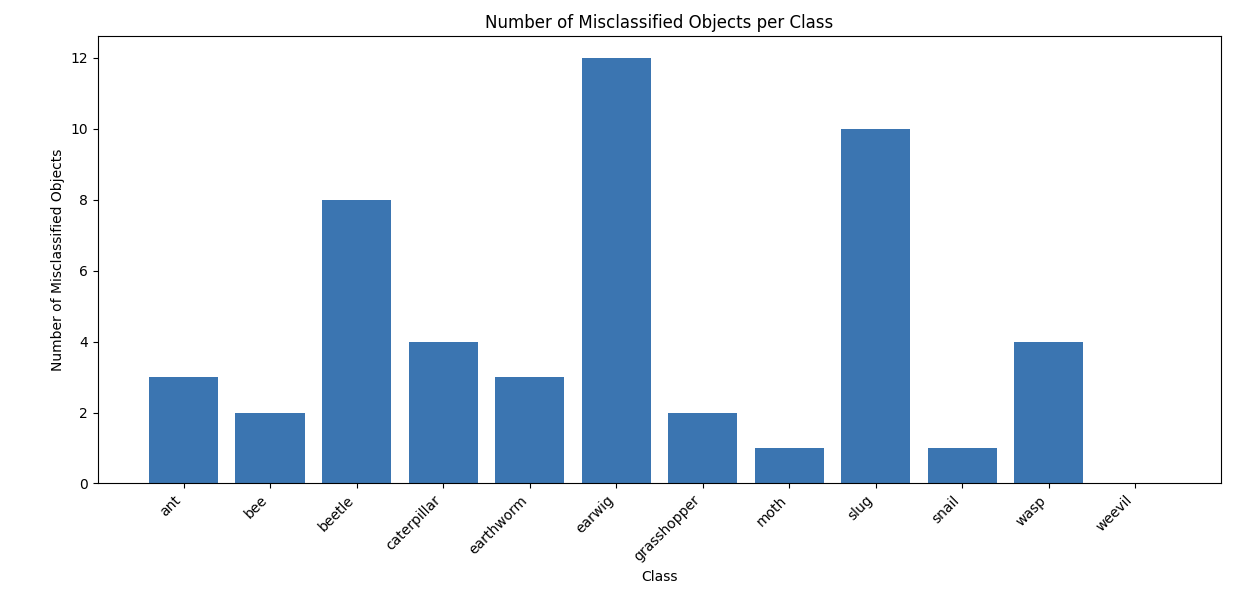

- The high misclassification rates for earwig, slug, and beetle likely stem from their similar colour and shape features, making them visually hard to distinguish. Additionally, mosaic and resizing augmentations (which our base model has) may blur fine details such as antennae and shells that are crucial for accurate classification.

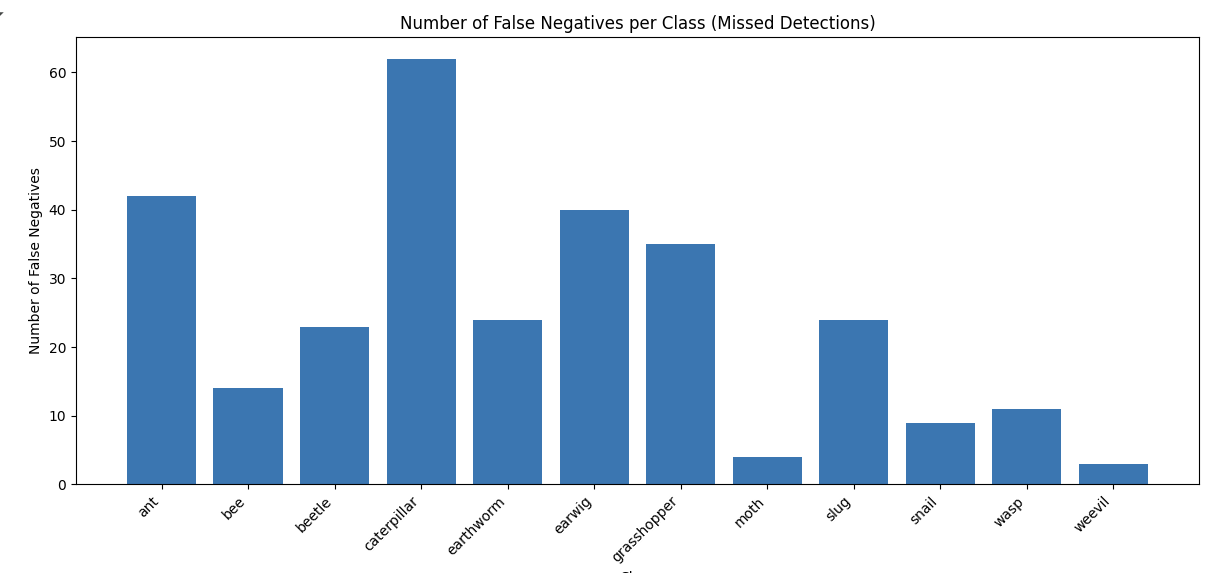

- The high number of missed detections is likely due to small or camouflaged insects like caterpillars, ants, and earwigs blending into their surroundings, making them difficult to detect. Additionally, dataset imbalance and low input resolution reduce the model’s ability to learn distinct features, while a high confidence threshold may be filtering out valid detections during post-processing.
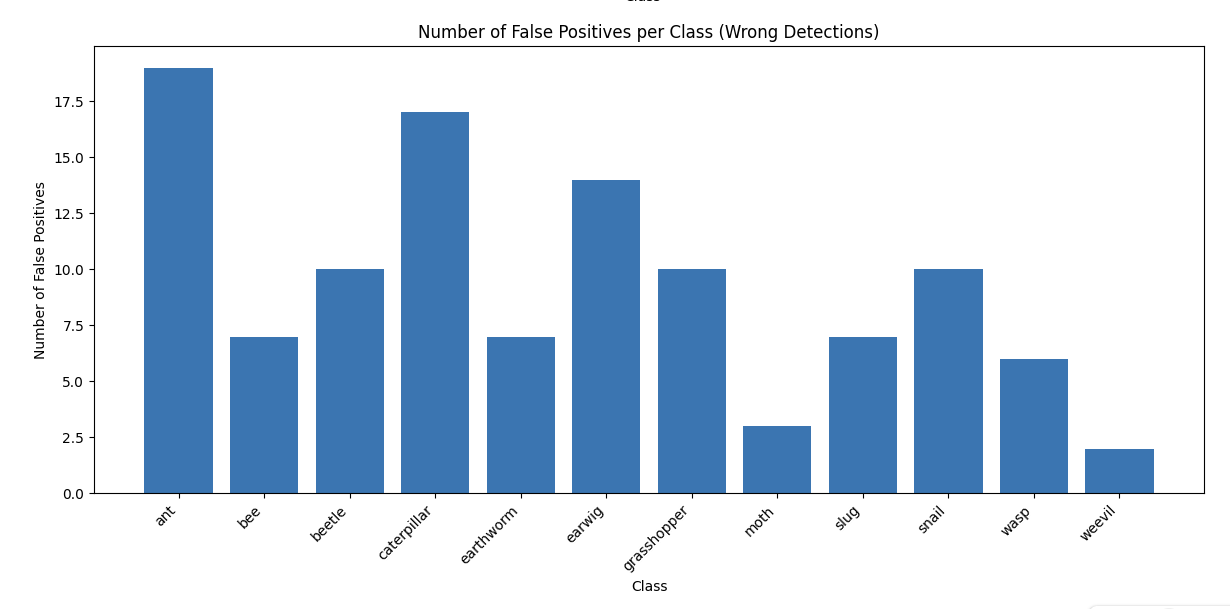
- Similarly, high false positives are likely caused by visual similarity between insects (e.g., ants, caterpillars, earwigs), background clutter that mimics insect features. It could also be due to class imbalancs especially towards ants.

# Our focus:
- Precision is higher than recall: confidence calibration and filtering
- Data Imbalance and feature bias
- Small Object and Localisation
- Looking and focusing more into the ants, caterpillars, earwigs, beetles and slugs classes

# Mosaic and Mixup testing

------------------------------------------

- redefining loss or prediction layers
1. trying WloYv3 loss (mimicing its behaviour due to limitations in YOLOv8n wrappers)



In [ ]:
# Load the hypertuned YOLOv8n model

def call_model_mixup_mos(epoch_size=20, image_size=640, mosaic_amount=1.0, mix_up_amount=0.0):
  model= YOLO("yolov8n.pt")

  train_res = model.train(
      data=str(data_yaml_path),
      batch=-1,
      device=0,
      amp=True,

      epochs=epoch_size,
      imgsz=image_size,
      mosaic=mosaic_amount,
      mixup=mix_up_amount,
      cache=True,


      project="pests_fast",
      name="yolov8n_wiou_like",
  )

  # Validate the Model
  val_results = model.val(
      data=str(data_yaml_path),
      split="val",
      batch=16,
      device=0,
      iou = 0.5,
      workers=2
  )


  # Test the Model
  sample_dir = local_path / "test" / "images"
  test_res = model.predict(
      source=str(sample_dir),
      batch=16,
      imgsz=image_size,
      device=0,
      save=True,
      project="runs/detect",
      name="pest_predictions_wloyv3_like" # Give it a new name

  )
  base_evaluation_metrics(val_results, train_res)
  IoUmeanstd(test_res)
  get_inference_time_and_fps(test_res)



In [ ]:
image_size_list = [512, 640, 896, 1024]
mosaic_list = [0.1, 0.3, 0.5]
mixup_list = [0.0, 0.2]

# DUE TO RAM ISSUES, CALLED SEPARATELY.
# Running on contsant 20 epochs for time
# Setting baseline
call_model_mixup_mos()


call_model_mixup_mos(20, image_size_list[0], mosaic_list[0], mixup_list[0])
call_model_mixup_mos(20, image_size_list[0], mosaic_list[0], mixup_list[1])

call_model_mixup_mos(20, image_size_list[0], mosaic_list[1], mixup_list[0])
call_model_mixup_mos(20, image_size_list[0], mosaic_list[1], mixup_list[1])


call_model_mixup_mos(20, image_size_list[0], mosaic_list[2], mixup_list[0])
call_model_mixup_mos(image_size_list[0], mosaic_list[2], mixup_list[1])


# best 640 config (already done)
call_model_mixup_mos(20, 640, 0.3, 0.0)

# resolution sweep with same augmentations
call_model_mixup_mos(20, 896, 0.3, 0.0)
call_model_mixup_mos(20, 1024, 0.3, 0.0)
call_model_mixup_mos(20, 512, 0.3, 0.0)



# Mimicking the WIoUv3 box loss function

------------------------------------------



In [ ]:

def call_model_WIoU(box_amount=7.5, dfl_amount=1.5):
  model= YOLO("yolov8n.pt")

  train_res = model.train(
      data=str(data_yaml_path),
      batch=-1,
      device=0,
      amp=True,
      epochs=20,
      imgsz=640,
      cache=True,

      # CHANGES
      box=box_amount,
      dfl=dfl_amount,

      project="pests_fast",
      name="yolov8n_wiou_like",
  )

  # Validate the Model
  val_results = model.val(
      data=str(data_yaml_path),
      split="val",
      batch=16,
      device=0,
      iou = 0.5,
      workers=2
  )


  # Test the Model
  sample_dir = local_path / "test" / "images"
  test_res = model.predict(
      source=str(sample_dir),
      batch=16,
      imgsz=640,
      device=0,
      save=True,
      project="runs/detect",
      name="pest_predictions_wloyv3_like" # Give it a new name

  )
  base_evaluation_metrics(val_results, train_res)
  IoUmeanstd(test_res)
  get_inference_time_and_fps(test_res)


In [ ]:
box_list = [7.5, 10, 12.5]
dlf_list = [1.5, 2.0, 2.5]


# DUE TO RAM ISSUES, CALLED SEPARATELY.
# Running on contsant 20 epochs for time
# Setting baseline
call_model_WIoU(box_list[0], box_list[0])

call_model_WIoU(box_list[0], box_list[1])
call_model_WIoU(box_list[0], box_list[2])

call_model_WIoU(box_list[1], box_list[0])
call_model_WIoU(box_list[1], box_list[1])
call_model_WIoU(box_list[1], box_list[2])

call_model_WIoU(box_list[2], box_list[2])





# Noise and Filter/Blur Analysis
--------------------------------------------------------
- Gaussian Noise
- Salt & Pepper
- Gaussian Blur

In [ ]:
# Noise and filter constants
APPLY_CORRUPTION = True
CORRUPT_TYPE = 'gaussian_blur'   # one of: 'gaussian_noise', 'salt_pepper_noise', 'gaussian_blur'
CORRUPT_STRENGTH = 0.5           # e.g., 0.05 = 5% noise or 5x5 kernel blur

In [ ]:
import cv2

# Noise and filter/blur analysis
def apply_corruption_to_folder(source_img_dir, destination_img_dir, corruption_type, strength=0.01):
    """
    Copies images from source to destination and applies a specified corruption.

    Args:
        source_img_dir (pathlib.Path): Directory containing original images.
        destination_img_dir (pathlib.Path): Target directory for corrupted images.
        corruption_type (str): 'gaussian_noise', 'salt_pepper_noise', 'gaussian_blur'.
        strength (float/int): Magnitude of the corruption.
    """
    # Determine corresponding label directories
    source_lbl_dir = source_img_dir.parent / "labels"
    destination_lbl_dir = destination_img_dir.parent / "labels"

    # Remove existing destination directories if they exist
    if destination_img_dir.exists():
        shutil.rmtree(destination_img_dir)
    if destination_lbl_dir.exists():
        shutil.rmtree(destination_lbl_dir)

    # Copy images and labels
    shutil.copytree(source_img_dir, destination_img_dir)
    if source_lbl_dir.exists():
        shutil.copytree(source_lbl_dir, destination_lbl_dir)


    if corruption_type == 'gaussian_noise':
        # Mean=0, standard deviation=strength * 255
        sigma = int(strength * 255)
        print(f"\nApplying {corruption_type} (Sigma: {sigma}) to images in {destination_img_dir.name}...")

        for img_file in destination_img_dir.glob('*.jpg'): # Adjust extension if needed
            img = cv2.imread(str(img_file))
            if img is None:
                continue

            img_f = img.astype(np.float32)
            noise = np.random.normal(0, sigma, img.shape).astype(np.float32)
            corrupted_img = img_f + noise
            corrupted_img = np.clip(corrupted_img, 0, 255).astype(np.uint8)

            # Save the corrupted image, overwriting the copy
            cv2.imwrite(str(img_file), corrupted_img)

    elif corruption_type == 'salt_pepper_noise':
        ratio = strength # Ratio of pixels to corrupt
        print(f"\nApplying {corruption_type} (Ratio: {ratio}) to images in {destination_img_dir.name}...")

        for img_file in destination_img_dir.glob('*.jpg'): # Adjust extension if needed
            img = cv2.imread(str(img_file))
            if img is None:
                continue

            corrupted_img = img.copy()
            h, w, c = img.shape
            num_pixels = int(ratio * h * w)

            # Salt (white)
            ys = np.random.randint(0, h, num_pixels)
            xs = np.random.randint(0, w, num_pixels)
            corrupted_img[ys, xs, :] = 255

            # Pepper (black)
            ys = np.random.randint(0, h, num_pixels)
            xs = np.random.randint(0, w, num_pixels)
            corrupted_img[ys, xs, :] = 0

            cv2.imwrite(str(img_file), corrupted_img)

    elif corruption_type == 'gaussian_blur':
        sigma = float(strength)

        for img_file in destination_img_dir.glob('*.jpg'): # Adjust extension if needed
            img = cv2.imread(str(img_file))
            if img is None:
                continue

            corrupted_img = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma, sigmaY=sigma)

            cv2.imwrite(str(img_file), corrupted_img)

    print("Corruption application complete.")


if (APPLY_CORRUPTION):
  # Create a new validation directory for the corrupted test set
  original_val_path = local_path / "valid" / "images"
  corrupt_val_path = local_path / "valid_noisy" / "images"

  # Apply corruption to the copied test set
  # We use 'valid' here since YOLOv8 validation defaults to the 'val' split name.
  apply_corruption_to_folder(
      original_val_path,
      corrupt_val_path,
      CORRUPT_TYPE,
      CORRUPT_STRENGTH
  )

  # Update the YAML to point to the corrupted validation set for the experiment
  data_cfg_corrupted = data_cfg.copy()
  data_cfg_corrupted['val'] = "valid_noisy/images"
  data_yaml_path_corrupted = local_path / "data_corrupted.yaml"

  with open(data_yaml_path_corrupted, "w") as f:
      yaml.safe_dump(data_cfg_corrupted, f)
  print("Wrote corrupted config:", data_yaml_path_corrupted)

In [ ]:
model = YOLO("yolov8n.pt")

# Train the mode
# comment/uncomment lines with device=0 for Colab and device="cpu" for personal
# only one of the above should be commented out
start = time.time()
train_res = model.train(
    data=str(data_yaml_path_corrupted if APPLY_CORRUPTION else data_yaml_path),
    epochs=20,
    imgsz=640,
    batch=-1,
    device=0,
    cache=True,          # cache dataset in RAM/Disk for speed
    amp=True,            # mixed precision
    project="pests_fast",
    name="yolov8n_colab",
    plots=False
)


# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = model.val(
    data=str(data_yaml_path_corrupted if APPLY_CORRUPTION else data_yaml_path),
    split="val",
    batch=16,
    iou=0.5,
    device=0,
    workers=2
)


# Test the Model (as per YOLOv8n website)
sample_dir = local_path / "test" / "images"
start = time.time()
test_res = model.predict(
    source=str(sample_dir),
    batch=16,
    imgsz=640,
    device=0,
    save=True,
    project="runs/detect",
    name="pest_predictions"
)

base_evaluation_metrics(val_results, train_res)
IoUmeanstd(test_res)
get_inference_time_and_fps(test_res)

# Duplication and Copy-Paste Augmentation
--------------------------------------------------------

In [ ]:

# Ensure local_path and names are defined
local_path = Path("/content/datasets/crop-pests")
data_yaml = yaml.safe_load(open(local_path / "data.yaml"))
names = data_yaml["names"]

minority_classes = ["Slugs", "Ants","Beetles", "Catterpillars", "Earwigs"]

# Get the class IDs for minority classes
minority_class_ids = [names.index(c) for c in minority_classes if c in names]

if not minority_class_ids:
    print("No valid minority classes specified from the dataset names.")
else:
    print(f"Minority classes for duplication: {minority_classes}")

    train_images_dir = local_path / "train" / "images"
    train_labels_dir = local_path / "train" / "labels"

    # Create directories for duplicated images and labels
    duplicated_images_dir = local_path / "train" / "images_duplicated"
    duplicated_labels_dir = local_path / "train" / "labels_duplicated"

    # Clean up previous runs if any
    if duplicated_images_dir.exists():
        shutil.rmtree(duplicated_images_dir)
    if duplicated_labels_dir.exists():
        shutil.rmtree(duplicated_labels_dir)

    duplicated_images_dir.mkdir(parents=True, exist_ok=True)
    duplicated_labels_dir.mkdir(parents=True, exist_ok=True)

    processed_images_count = 0
    duplicated_count = 0

    for label_file in train_labels_dir.glob("*.txt"):
        image_file = train_images_dir / f"{label_file.stem}.jpg"

        if image_file.exists():
            has_minority_class = False
            try:
                with open(label_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if parts:
                            class_id = int(parts[0])
                            if class_id in minority_class_ids:
                                has_minority_class = True
                                break # Found a minority class, no need to check further in this file
            except Exception as e:
                print(f"Error reading label file {label_file}: {e}")
                continue # Skip this file if there's an error

            if has_minority_class:
                processed_images_count += 1
                # Duplicate the image and label file

                new_image_name = f"{image_file.stem}_dup{1}{image_file.suffix}"
                new_label_name = f"{label_file.stem}_dup{1}{label_file.suffix}"

                new_image_path = duplicated_images_dir / new_image_name
                new_label_path = duplicated_labels_dir / new_label_name

                try:
                    # Read, rotate, and save the image
                    img = cv2.imread(str(image_file))
                    if img is not None:
                        rotated_img = cv2.rotate(img, cv2.ROTATE_180)
                        cv2.imwrite(str(new_image_path), rotated_img)
                    else:
                        print(f"Warning: Could not read image {image_file} for rotation.")
                        continue # Skip if image couldn't be read

                    shutil.copy2(str(label_file), str(new_label_path))
                    duplicated_count += 1
                except Exception as e:
                    print(f"Error duplicating files for {image_file}: {e}")


print(f"Total Duplicates: {duplicated_count}")

In [ ]:
# Copy-Paste Augmentation (with soft masks + size/box safety)
# NOTE: currently working with grey/green background
from pathlib import Path
from PIL import Image, ImageDraw, ImageFilter
import numpy as np, random, yaml, os

local_path = Path("/content/datasets/crop-pests")
data_yaml = yaml.safe_load(open(local_path / "data.yaml"))
names = data_yaml["names"]
# choose minority classes
minority_classes = ["Slugs", "Ants","Beetles", "Catterpillars", "Earwigs"]

BG_W, BG_H = 640, 640  # output size
NUM_TO_MAKE = 400      # how many composites to generate


MIN_NORM_AREA = 5e-4     # ignore ultra-tiny boxes when collecting

# paste-time scaling
SCALE_LO, SCALE_HI = 1.2, 3.0
MIN_PX = 24              # upsize tiny crops to at least this many pixels
FEATHER = 6              # mask feather radius (soft edge)
DEBUG_OUTLINE = False    # draw a red box so you can see the pasted region


# paths
train_images_dir = local_path / "train" / "images"
train_labels_dir = local_path / "train" / "labels"
out_img_dir = local_path / "train" / "images_cp"
out_lbl_dir = local_path / "train" / "labels_cp"
out_img_dir.mkdir(parents=True, exist_ok=True)
out_lbl_dir.mkdir(parents=True, exist_ok=True)

# class ids we want to oversample
minority_ids = [i for i, n in enumerate(names) if n in minority_classes]
print("Minority class ids:", {names[i]: i for i in minority_ids})

def compute_median_bg_color(image_dir, max_images=200, resize_to=(64, 64)):
    all_pixels = []

    for i, img_path in enumerate(image_dir.glob("*.jpg")):
        if i >= max_images:
            break
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            continue

        img = img.resize(resize_to, Image.BILINEAR)
        arr = np.asarray(img).reshape(-1, 3)
        all_pixels.append(arr)

    if not all_pixels:
        # fallback colour if nothing loaded
        return (128, 128, 128)

    all_pixels = np.concatenate(all_pixels, axis=0)  # shape (total_pixels, 3)
    median_rgb = np.median(all_pixels, axis=0).astype(np.uint8)
    return tuple(median_rgb.tolist())

def yolo_to_xyxy_norm(x, y, w, h):
    return (x - w/2, y - h/2, x + w/2, y + h/2)

def clip_xyxy_px(x1, y1, x2, y2, W, H):
    x1 = max(0, min(W, x1)); y1 = max(0, min(H, y1))
    x2 = max(0, min(W, x2)); y2 = max(0, min(H, y2))
    if x2 <= x1 or y2 <= y1:
        return None
    return int(x1), int(y1), int(x2), int(y2)

def feather_mask(size, feather=6):
    m = Image.new("L", size, 255)
    # simple blur gives a soft edge; you can replace with elliptical mask if you like
    return m.filter(ImageFilter.GaussianBlur(radius=feather))

median_bg_color = compute_median_bg_color(train_images_dir)

def get_background():
    return Image.new("RGB", (BG_W, BG_H), median_bg_color)

def paste_one(source_img_path, bbox_norm, out_stem, class_id):
    src = Image.open(source_img_path).convert("RGB")
    W, H = src.size

    x, y, w, h = bbox_norm
    if w*h < MIN_NORM_AREA:
        return False

    # 1) convert to pixels and clip
    x1n,y1n,x2n,y2n = yolo_to_xyxy_norm(x, y, w, h)
    x1 = x1n * W; y1 = y1n * H; x2 = x2n * W; y2 = y2n * H
    clipped = clip_xyxy_px(x1,y1,x2,y2,W,H)
    if clipped is None:
        return False
    x1,y1,x2,y2 = clipped

    # crop & sanity
    crop = src.crop((x1,y1,x2,y2))
    cw, ch = crop.size
    if cw < 2 or ch < 2:
        return False

    # scaling up if tiny
    s = random.uniform(SCALE_LO, SCALE_HI)
    ow = max(MIN_PX, int(cw * s))
    oh = max(MIN_PX, int(ch * s))
    crop = crop.resize((ow, oh), Image.LANCZOS)
    mask = feather_mask((ow, oh), FEATHER)

    # get the background
    bg = get_background()

    # choose paste position
    BW, BH = bg.size
    if ow >= BW or oh >= BH:
        return False
    px = random.randint(0, BW - ow)
    py = random.randint(0, BH - oh)

    # 6) paste with alpha
    bg.paste(crop, (px, py), mask)

    # compute normalised box on the background
    cx = (px + ow/2) / BW
    cy = (py + oh/2) / BH
    ww = ow / BW
    hh = oh / BH
    cx = max(0.0, min(1.0, cx))
    cy = max(0.0, min(1.0, cy))
    ww = max(1e-6, min(1.0, ww))
    hh = max(1e-6, min(1.0, hh))

    # save it
    img_path = out_img_dir / f"{out_stem}.jpg"
    lbl_path = out_lbl_dir / f"{out_stem}.txt"
    bg.save(img_path)
    with open(lbl_path, "w") as f:
        f.write(f"{class_id} {cx:.6f} {cy:.6f} {ww:.6f} {hh:.6f}\n")
    return True

# collect small instances of minority classes
instances = []
for lbl_file in sorted(train_labels_dir.glob("*.txt")):
    img_path = train_images_dir / f"{lbl_file.stem}.jpg"
    if not img_path.exists():
        continue
    for line in open(lbl_file):
        p = line.strip().split()
        if len(p) < 5:
            continue
        cid = int(float(p[0]))
        if cid not in minority_ids:
            continue
        x,y,w,h = map(float, p[1:5])
        if w*h >= MIN_NORM_AREA:
            # keep the instance; we’ll still upscale when pasting
            instances.append({"img_path": img_path, "class_id": cid, "bbox":[x,y,w,h]})

print(f"Collected {len(instances)} minority instances.")

if not instances:
    raise SystemExit("No instances found. Check 'minority_classes' names and labels.")

# generate the copy_paste
made = 0
for i in range(NUM_TO_MAKE):
    inst = random.choice(instances)
    stem = f"cp_{i:05d}_{Path(inst['img_path']).stem}"
    ok = paste_one(
        source_img_path=str(inst["img_path"]),
        bbox_norm=inst["bbox"],
        out_stem=stem,
        class_id=inst["class_id"]
    )
    if ok:
        made += 1

print(f" Generated {made}/{NUM_TO_MAKE} copy-paste images into:\n  {out_img_dir}\n  {out_lbl_dir}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Generate Training File List Including Duplicated Images (No Copying)

import os
from pathlib import Path

# Assume 'local_path' is defined from previous cells

original_train_images_dir = local_path / "train" / "images"
# This is for duplicates
duplicated_images_dir = local_path / "train" / "images_duplicated"
# this is the copy paste
copy_paste_images_dir = local_path / "train" / "images_cp"

train_file_list_path = local_path / "train_images_list.txt"

all_train_image_paths = []

# Collect original image paths
if original_train_images_dir.exists():
    print(f"Collecting images from: {original_train_images_dir}")
    all_train_image_paths.extend([str(p.resolve()) for p in original_train_images_dir.glob("*.jpg")])
else:
    print(f"Warning: Original training images directory not found at {original_train_images_dir}")


# Collect duplicated image paths
if duplicated_images_dir.exists():
    print(f"Collecting images from: {duplicated_images_dir}")
    all_train_image_paths.extend([str(p.resolve()) for p in duplicated_images_dir.glob("*.jpg")])
else:
    print(f"Warning: Duplicated images directory not found at {duplicated_images_dir}")

# Collect copy-paste image paths (if the directory exists)
if copy_paste_images_dir.exists():
    print(f"Collecting images from: {copy_paste_images_dir}")
    all_train_image_paths.extend([str(p.resolve()) for p in copy_paste_images_dir.glob("*.jpg")])
else:
    print(f"Copy-paste images directory not found at {copy_paste_images_dir} (skipping).")


# Write the file list to a text file
with open(train_file_list_path, "w") as f:
    for img_path in all_train_image_paths:
        f.write(f"{img_path}\n")

print(f"\nGenerated training image file list at: {train_file_list_path}")
print(f"Total images included in the file list: {len(all_train_image_paths)}")

In [ ]:
# Update data.yaml to Use the Training File List


# NOTE: Assume 'local_path' and 'train_file_list_path' are defined from previous cells

data_yaml_path = local_path / "data.yaml"

# Load the existing data.yaml content
if data_yaml_path.exists():
    with open(data_yaml_path, "r") as f:
        data_cfg = yaml.safe_load(f)
else:
    print(f"Warning: data.yaml not found at {data_yaml_path}. Creating a new one.")
    data_cfg = {
        "path": str(local_path), # Keep the root path for val/test
        "val":   "valid/images",
        "test":  "test/images",
        "nc": 12,
        "names":
         [
          "Ants",
          "Bees",
          "Beetles",
          "Catterpillars",
          "Earthworms",
          "Earwigs",
          "Grasshoppers",
          "Moths",
          "Slugs",
          "Snails",
          "Wasps",
          "Weevils",
        ]
    }

data_cfg["train"] = str(train_file_list_path.resolve())


# Write the updated data.yaml file
with open(data_yaml_path, "w") as f:
    yaml.safe_dump(data_cfg, f)


print(yaml.safe_dump(data_cfg))


In [ ]:
model = YOLO("yolov8n.pt")

train_res = model.train(
    # Use the data.yaml file which now points to the training image file list
    data=str(local_path/"data.yaml"),
    epochs=20,
    imgsz=640,
    batch=-1,
    device=0,
    cache=True,          # cache dataset in RAM/Disk for speed
    amp=True,            # mixed precision
    project="pests_fast",
    name="yolov8n_colab",
    plots=False
)


# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = model.val(
    data=str(local_path/"data.yaml"),
    split="val",
    batch=16,
    iou=0.5,
    device=0,
    workers=2
)


# Test the Model (as per YOLOv8n website)
sample_dir = local_path / "test" / "images"
start = time.time()
test_res = model.predict(
    source=str(sample_dir),
    batch=16,
    imgsz=640,
    device=0,
    save=True,
    project="runs/detect",
    name="pest_predictions"
)

base_evaluation_metrics(val_results, train_res)
IoUmeanstd(test_res)
get_inference_time_and_fps(test_res)

In [ ]:
base_evaluation_metrics(val_results, train_res)